# Bibliotecas Necessárias para Executar Simulação


In [1]:
!pip install torch
!pip install tensorflow
%pip install conda


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Pré-Processamento

In [2]:
# Subida do Banco de Dados
import pandas as pd

df = pd.read_excel (r'C:\Users\vimed\Downloads\Dados_Mestrado_07_05_2025 (1).NeW_Teste_@_Ajustado_Ajuste.xlsx' , sheet_name= 'Banco_Geral_Oficial' , engine='openpyxl')

# Limpeza dos Dados
df.columns = df.columns.str.replace('\t', '').str.strip()
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


#Conversão das Datas de Nascimentos Incorretas ,caso contrário,filtragem/remoção

def remover_datas_invalidas(df, coluna="datanasc"):
    df[coluna] = pd.to_datetime(df[coluna], dayfirst=True, errors='coerce')

    df = df.dropna(subset=[coluna]).reset_index(drop=True)

    return df

df = remover_datas_invalidas(df)
df['datanasc']

C:\Users\vimed\AppData\Local\Temp\ipykernel_71872\2100780968.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


0      1957-03-11
1      1959-07-04
2      1940-10-08
3      1934-02-25
4      1983-11-15
          ...    
3092   1994-01-05
3093   1982-04-17
3094   1988-12-06
3095   1974-02-03
3096   1970-05-18
Name: datanasc, Length: 3097, dtype: datetime64[ns]

In [3]:
df_ciclovias = pd.read_excel(r'C:\Users\vimed\Downloads\dados_km_ciclovias.xlsx')

df = df.merge(df_ciclovias ,right_on='id',left_on='id',how='inner')

## Estruturação de uma Cópia do Dataframe para Execução do Modelo
df_original =df.copy()

# Processamento

In [4]:
#Foi necessario criar outro dataframe para Calorias para Não dar problema

df_calorias = pd.read_excel(
    r'C:\Users\vimed\Downloads\Dados_Mestrado_07_05_2025 (1).NeW_Teste_@_Ajustado_Ajuste.xlsx',
    sheet_name='Tabela Auxiliar_Consumo Caloric',
    engine='openpyxl'
)
df_calorias.drop(columns=[
    'Coluna1',
    'Coluna2',
    'Unnamed: 4',
    'Unnamed: 5',
    'Unnamed: 6',
    'Unnamed: 7',
    'Chavemento pof',
    'Kcal-dia.1'
], inplace=True)

df_calorias

,Chavemento pof e ISA,Kcal-dia
0,M|Adultos|Outros|Renda Alta|Ensino Médio e Sup...,1306.500
1,M|Jovens e Adolescentes|Outros|Renda Média-Bai...,829.630
2,M|Adultos|Outros|Renda Média-Baixa|Até Ensino ...,1455.890
3,F|Adultos|Outros|Renda Alta|Ensino Médio e Sup...,2636.490
4,M|Adultos|Branca|Renda Média|Ensino Médio e Su...,1420.615
...,...,...
2357,M|Adultos|Outros|Renda Não Declarada|Até Ensin...,1161.565
2358,M|Adultos|Branca|Renda Não Declarada|Ensino Mé...,2029.671
2359,M|Adultos|Branca|Renda Não Declarada|Até Ensin...,2046.021
2360,F|Idosos|Outros|Renda Média|Até Ensino Fundame...,816.652


In [5]:
# Bibliotecas Necessárias para a Simulação
import time
import torch
import numpy as np
import pandas as pd
import random
import warnings

# Necessária a Incorporação  de uma Fixador-Aleatorio para Garantir Reprodutibilidade do Modelo Probabilistico
SEED = 42
random.seed(SEED)   # Fixador para controle dos numeros aleatorios gerados do Python
np.random.seed(SEED)  # Fixador para controle dos numeros aleatorios gerados da Biblioteca Numpy
torch.manual_seed(SEED)  # Fixador para controle dos numeros aleatorios gerados da Biblioteca do Pythorch

if torch.cuda.is_available(): # Verificação se há disponivel uma CPU CUDA Compatível, se houver, ele garante que todos os processos paralelizados possuam o mesmo fixador em paralelo.
    torch.cuda.manual_seed_all(SEED)

## Conversão e Padronização  de Datas na Simulação com Trataemnto de ERRO
def converter_data_brasil_ou_americano(data):
    if pd.isna(data):
        return pd.NaT
    if isinstance(data, (pd.Timestamp, pd.DatetimeTZDtype)):
        return data
    if isinstance(data, str):
        data = data.strip()
    if data == '':
        return pd.NaT
    try:
        return pd.to_datetime(data, format='%d/%m/%Y', errors='raise')
    except Exception:
        try:
            return pd.to_datetime(data, format='%Y-%m-%d', errors='raise')
        except Exception:
            warnings.warn(f"Erro ao tentar padronizar/converter: {data}. Retornando NaT.")
        return pd.NaT
            
#####################################################################################################
#Execução das Simulações Via Pytorch

# Função da Simulação Geral
def simulacao_torch(df_original, df_calorias, num_semanas, num_simulacoes):

    inicio_total = time.time()
    df = df_original.copy().reset_index(drop=True)
    
    
    # Conferência das  colunas importantes para a simulação
    colunas_obrigatorias = ['peso', 'datanasc', 'sexo', 'altura', 'fatores_atividade_fisica', 'id', 'Categorias']
    for coluna in colunas_obrigatorias:
        if coluna not in df.columns:
            raise ValueError(f"Coluna Ausente: {coluna}")
        
        
    # Processamento das Datas de Aniversários, Idade e Peso, e Sexo
    dias_nascimento = df['datanasc'].dt.normalize().values.astype('datetime64[D]').astype('int64')
    num_individuos = len(df)
    ids = df['id'].values
    peso_inicial = df['peso'].astype(float).values.astype(np.float32)
    altura = df['altura'].astype(float).values.astype(np.float32)
    sexo = (df['sexo'].astype(str) == 'M').astype(np.float32).values
    
    #Mapeando as Categorias dos Indviduos e fazendo a contagem de individuos por categoria unica
    categorias, indices_categorias = np.unique(df['Categorias'].values, return_inverse=True)
    indices_categorias = indices_categorias.astype(np.int64)
    num_categorias = len(categorias)

    #Uso do  Dataframe das Calorias por Categorias para Comparação com o Banco de Dados Originais
    mapeamento_calorias_categoria = {}
    for categoria in categorias:
        valores = df_calorias.loc[df_calorias['Chavemento pof e ISA'] == categoria, 'Kcal-dia'] \
                        .dropna().astype(float).values.astype(np.float32)
        mapeamento_calorias_categoria[categoria] = valores
        
    # Mapeamento  e Uso do Dataframe dos Fatores de Atividades fisica  para Comparação com o Banco de Dados Originais
    mapeamento_fatores_categoria = {}
    for categoria in categorias:
        # Verifica se a categoria existe no dataframe original e tem fatores
        fatores_categoria = df.loc[df['Categorias'] == categoria, 'fatores_atividade_fisica']
        if len(fatores_categoria) > 0:
            valores = fatores_categoria.dropna().astype(str).str.replace(',', '.').astype(float) \
                    .unique().astype(np.float32)
        else:
            # Valor padrão caso não existam fatores para esta categoria
            valores = np.array([1.2], dtype=np.float32)
        mapeamento_fatores_categoria[categoria] = valores
    
    # Para calorias
    valores_concatenados = np.concatenate([mapeamento_calorias_categoria[c] for c in categorias]) if len(categorias) > 0 else np.array([], dtype=np.float32)
    indices_categorias_map_cal = {}
    comeco_idx = 0
    for c in categorias:
        fim_idx = comeco_idx + len(mapeamento_calorias_categoria[c])
        indices_categorias_map_cal[c] = (comeco_idx, fim_idx)
        comeco_idx = fim_idx

    # Para fatores de atividade física
    fatores_concatenados = np.concatenate([mapeamento_fatores_categoria[c] for c in categorias]) if len(categorias) > 0 else np.array([], dtype=np.float32)
    indices_categorias_map_fat = {}
    comeco_idx = 0
    for c in categorias:
        fim_idx = comeco_idx + len(mapeamento_fatores_categoria[c])
        indices_categorias_map_fat[c] = (comeco_idx, fim_idx)
        comeco_idx = fim_idx

    # Converter para tensores realizarem os Calculos nos Arrays Multidimensionais
    tensor_peso_inicial = torch.tensor(peso_inicial)
    tensor_altura = torch.tensor(altura)
    tensor_sexo = torch.tensor(sexo)
    tensor_dias_nascimento = torch.tensor(dias_nascimento)
    tensor_indices_categorias = torch.tensor(indices_categorias, dtype=torch.long)
    tensor_valores_concatenados = torch.tensor(valores_concatenados, dtype=torch.float32) if valores_concatenados.size else torch.empty((0,), dtype=torch.float32)
    tensor_fatores_concatenados = torch.tensor(fatores_concatenados, dtype=torch.float32) if fatores_concatenados.size else torch.empty((0,), dtype=torch.float32)
    
    # Input para Data Inicial para o Inicio da Simulação
    data_base = np.datetime64('2015-01-01').astype('datetime64[D]').astype('int64')
    #Armazenamento dos Resultados
    resultados = []
        
    for simulacao in range(num_simulacoes):
        tempo_inicio = time.time()
        
        # Preservação do Peso Inicial para o  Inicio da Simulação
        peso_atual = tensor_peso_inicial.clone()
        
        # Array  para armazenar os balanços Energeticos para Cada Simulação
        balanco_semanas = torch.empty((num_individuos, num_semanas), dtype=torch.float32)

        for semana in range(num_semanas):
            dias_passados = semana * 7
            dia_atual = data_base + dias_passados
            idade = ((dia_atual - tensor_dias_nascimento) // 365).to(torch.float32)

            # Cálculo da TMB (Taxa Metabólica Basal)  do St. Miffins(Condicionado para Homens e Mulheres)
            tmb_dia = (10.0 * peso_atual) + (6.25 * tensor_altura * 100.0) - (5.0 * idade) + (5.0 * tensor_sexo) + (-161.0 * (1.0 - tensor_sexo))
            
            # Sorteio dos  Aleatorios por Categorias dos Fatores de Atividade Fisica para cada semana
            inicio_fatores = torch.tensor([indices_categorias_map_fat[c][0] for c in categorias], dtype=torch.long)
            fim_fatores = torch.tensor([indices_categorias_map_fat[c][1] for c in categorias], dtype=torch.long)
            comprimentos_fatores = (fim_fatores - inicio_fatores).to(torch.long)
            comprimentos_fatores_por_ind = comprimentos_fatores[tensor_indices_categorias]  # comprimento por indivíduo
            # sorteio vetorizado de um fator por indivíduo
            comprimentos_safe = comprimentos_fatores_por_ind.clone()
            comprimentos_safe[comprimentos_safe == 0] = 1
            indices_aleatorios_fatores = torch.floor(torch.rand(num_individuos) * comprimentos_safe.to(torch.float32)).to(torch.long)
            inicio_por_ind = inicio_fatores[tensor_indices_categorias]
            indices_fatores = inicio_por_ind + indices_aleatorios_fatores
            # selecionar fator sorteado a partir do vetor concatenado de fatores
            if tensor_fatores_concatenados.numel() > 0:
                fator_sorteado = tensor_fatores_concatenados[indices_fatores]
            else:
                fator_sorteado = torch.full((num_individuos,), 1.2, dtype=torch.float32)

            # Calculo do Balanço Energético
            gasto_semanal = tmb_dia * 7.0 * fator_sorteado
            
            
            #  Padrão Alimentar por Categoria que ocorrem a cada semana.
            inicio_cal = torch.tensor([indices_categorias_map_cal[c][0] for c in categorias], dtype=torch.long)
            fim_cal = torch.tensor([indices_categorias_map_cal[c][1] for c in categorias], dtype=torch.long)
            comprimentos_cal = (fim_cal - inicio_cal).to(torch.long)
            comprimentos_cal_por_ind = comprimentos_cal[tensor_indices_categorias]
            
            comprimentos_cal_safe = comprimentos_cal_por_ind.clone()
            comprimentos_cal_safe[comprimentos_cal_safe == 0] = 1
            # sorteio de 7 consumos por indivíduo
            indices_aleatorios_calorias = torch.floor(torch.rand((num_individuos, 7)) * comprimentos_cal_safe.unsqueeze(1).to(torch.float32)).to(torch.long)
            inicio_por_ind_cal = inicio_cal[tensor_indices_categorias].unsqueeze(1)
            idxs = inicio_por_ind_cal + indices_aleatorios_calorias
            
            if tensor_valores_concatenados.numel() > 0:
                consumo_diario = torch.clamp(tensor_valores_concatenados[idxs], min=800.0, max=5000.0)
            else:
                consumo_diario = torch.full((num_individuos, 7), 2000.0, dtype=torch.float32)
            consumo_semanal = consumo_diario.sum(dim=1)

            # Calculo do Balanço Energético Energetico que é feito semanalmente
            balanco_energetico = consumo_semanal - gasto_semanal
            
            
            ## Implementação das Políticas de Restrição e Aplicação da Suavização Exponencial Simples nas primeiras 40 semanas
            limite_deficit_base = peso_atual * 0.008 * 7700.0
            limite_superavit_base = peso_atual * 0.012 * 7700.0
            fator_decaimento = (0.92 ** min(semana, 40))
            limite_deficit = limite_deficit_base * fator_decaimento
            limite_superavit = limite_superavit_base * fator_decaimento

            balanco_energetico = torch.clamp(balanco_energetico, min=-limite_deficit, max=limite_superavit)
            balanco_semanas[:, semana] = balanco_energetico

            # Atualização do Peso a Cada Semana
            peso_atual = peso_atual + (balanco_energetico / 7700.0)
            # Verificação dos Pesos
            peso_final = peso_atual.detach().cpu().numpy()
        peso_inicial_array = tensor_peso_inicial.detach().cpu().numpy()
        
     
            
            #Conversão dos resultados  feitos nos tensores para os Dataframe
        balanco_cpu = balanco_semanas.detach().cpu().numpy()
        df_balanco = pd.DataFrame(balanco_cpu, columns=[f'semana_{i+1}' for i in range(num_semanas)])
        df_balanco['id'] = ids
        df_balanco['simulacao'] = simulacao + 1
        # Validação dos Pesos Inidicias e Finais
        df_balanco['peso_inicial'] = peso_inicial_array
        df_balanco['peso_final'] = peso_final
        
        resultados.append(df_balanco)

    return resultados

# Chamada da Função com  os Inputs de Semanas e Quantidades de Semanas Desejadas
resultados = simulacao_torch(df_original, df_calorias, num_semanas=314, num_simulacoes=100)


# Pós-Processamento

In [6]:
# Concatenando os resultados por simulação
df_simulacao = pd.concat(resultados, ignore_index=True)

# Contagem das semanas por ano
semanas_por_ano = 52
# Range de anos para percorrer (2015-2020)
anos = list(range(2015, 2021))

# Usar os pesos iniciais da simulação que já estão no dataframe de resultados
df_peso_inicial = df_simulacao[['id', 'peso_inicial']].drop_duplicates().copy()

# Calcula o peso por ano com base nas semanas da simulação
def calcular_peso_ano(df_sim, df_peso_inicial, anos, semanas_por_ano):
    pesos = {}
    for i, ano in enumerate(anos, start=1):
        semanas = i * semanas_por_ano
        colunas = [f'semana_{j+1}' for j in range(semanas)]
        
        # Verificar se existem semanas suficientes na simulação
        semanas_disponiveis = [col for col in colunas if col in df_sim.columns]
        
        if len(semanas_disponiveis) > 0:
            acumulado = df_sim.groupby('id')[semanas_disponiveis].mean()
            pesos[ano] = df_peso_inicial.set_index('id')['peso_inicial'] + (acumulado.sum(axis=1) / 7700)
        else:
            # Se não há semanas suficientes, usar o peso inicial
            pesos[ano] = df_peso_inicial.set_index('id')['peso_inicial']
    
    return pesos

# Transformação dos pesos
pesos_por_ano = calcular_peso_ano(df_simulacao, df_peso_inicial, anos, semanas_por_ano)

# Reindexação dos indivíduos, considerando o peso inicial na simulação, criando Dataframe final do ID único para peso e IMC
# Primeiro precisamos obter as categorias e altura do dataframe original
df_categorias_altura = df_original[['id', 'Categorias', 'altura']].drop_duplicates().copy()

df_final = df_categorias_altura.set_index('id')
df_final['Peso_2015_base'] = df_peso_inicial.set_index('id')['peso_inicial']

# Loop do cálculo ano a ano do Peso
for ano in anos:
    if ano in pesos_por_ano:
        df_final[f'Peso_{ano}'] = pesos_por_ano[ano].reindex(df_final.index)
    else:
        # Se não há dados para o ano, usar o ano anterior ou o base
        df_final[f'Peso_{ano}'] = df_final['Peso_2015_base']

# Cálculo dos IMCs
df_final['IMC_2015_base'] = df_final['Peso_2015_base'] / (df_final['altura'] ** 2)

# Loop do cálculo ano a ano do IMC
for ano in anos:
    df_final[f'IMC_{ano}'] = df_final[f'Peso_{ano}'] / (df_final['altura'] ** 2)

df_final.reset_index(inplace=True)

# Função para mostrar as estatísticas descritivas dos indivíduos, considerando peso e IMC
def formatar_describe_planilha(df, tipo):
    dados = {}
    base = df[f'{tipo}_2015_base'].describe()
    dados['Estatística'] = base.index.tolist() + ['n_pessoas']
    dados[f'{tipo}_2015_base'] = base.values.tolist() + [df[f'{tipo}_2015_base'].count()]
    
    for ano in anos:
        coluna = f'{tipo}_{ano}'
        if coluna in df.columns:
            d = df[coluna].describe()
            dados[coluna] = d.values.tolist() + [df[coluna].count()]
        else:
            dados[coluna] = [0] * len(base.index) + [0]  # Preencher com zeros se não existir
    
    return pd.DataFrame(dados).round(2)

# Exibir as estatísticas das Simulações
print("Estatísticas da Simulação")
print("\nPeso da Simulação (2015-2020)") 
print(formatar_describe_planilha(df_final, 'Peso').to_string(index=False))
print("\nIMC da Simulação (2015-2020)")
print(formatar_describe_planilha(df_final, 'IMC').to_string(index=False))

# Definição do último ano de Simulação 
ultimo_ano = anos[-1]
peso = df_final[f'Peso_{ultimo_ano}'].describe()
imc = df_final[f'IMC_{ultimo_ano}'].describe()

# Exibir estatística do último ano
print(f"\nResultados Finais {ultimo_ano} -")
print("\nPeso")
print(pd.DataFrame({
    'Estatística': peso.index.tolist() + ['n_pessoas'],
    'Valor': peso.values.tolist() + [df_final[f'Peso_{ultimo_ano}'].count()]
}).round(2).to_string(index=False))

print("\nIMC:")
print(pd.DataFrame({
    'Estatística': imc.index.tolist() + ['n_pessoas'],
    'Valor': imc.values.tolist() + [df_final[f'IMC_{ultimo_ano}'].count()]
}).round(2).to_string(index=False))



Estatísticas da Simulação

Peso da Simulação (2015-2020)
Estatística  Peso_2015_base  Peso_2015  Peso_2016  Peso_2017  Peso_2018  Peso_2019  Peso_2020
      count          767.00     767.00     767.00     767.00     767.00     767.00     767.00
       mean           70.75      66.73      66.21      65.71      65.24      64.78      64.35
        std           15.75      13.47      13.16      12.86      12.57      12.30      12.04
        min           34.00      34.57      34.20      33.86      33.56      33.28      33.03
        25%           60.00      57.32      57.06      56.78      56.61      56.44      56.41
        50%           69.00      65.38      65.21      64.78      64.20      63.98      63.62
        75%           80.00      74.61      73.88      73.05      72.42      71.94      71.38
        max          130.00     118.07     116.35     114.66     113.00     111.37     109.77
  n_pessoas          767.00     767.00     767.00     767.00     767.00     767.00     767.00

IM

# Visualização 

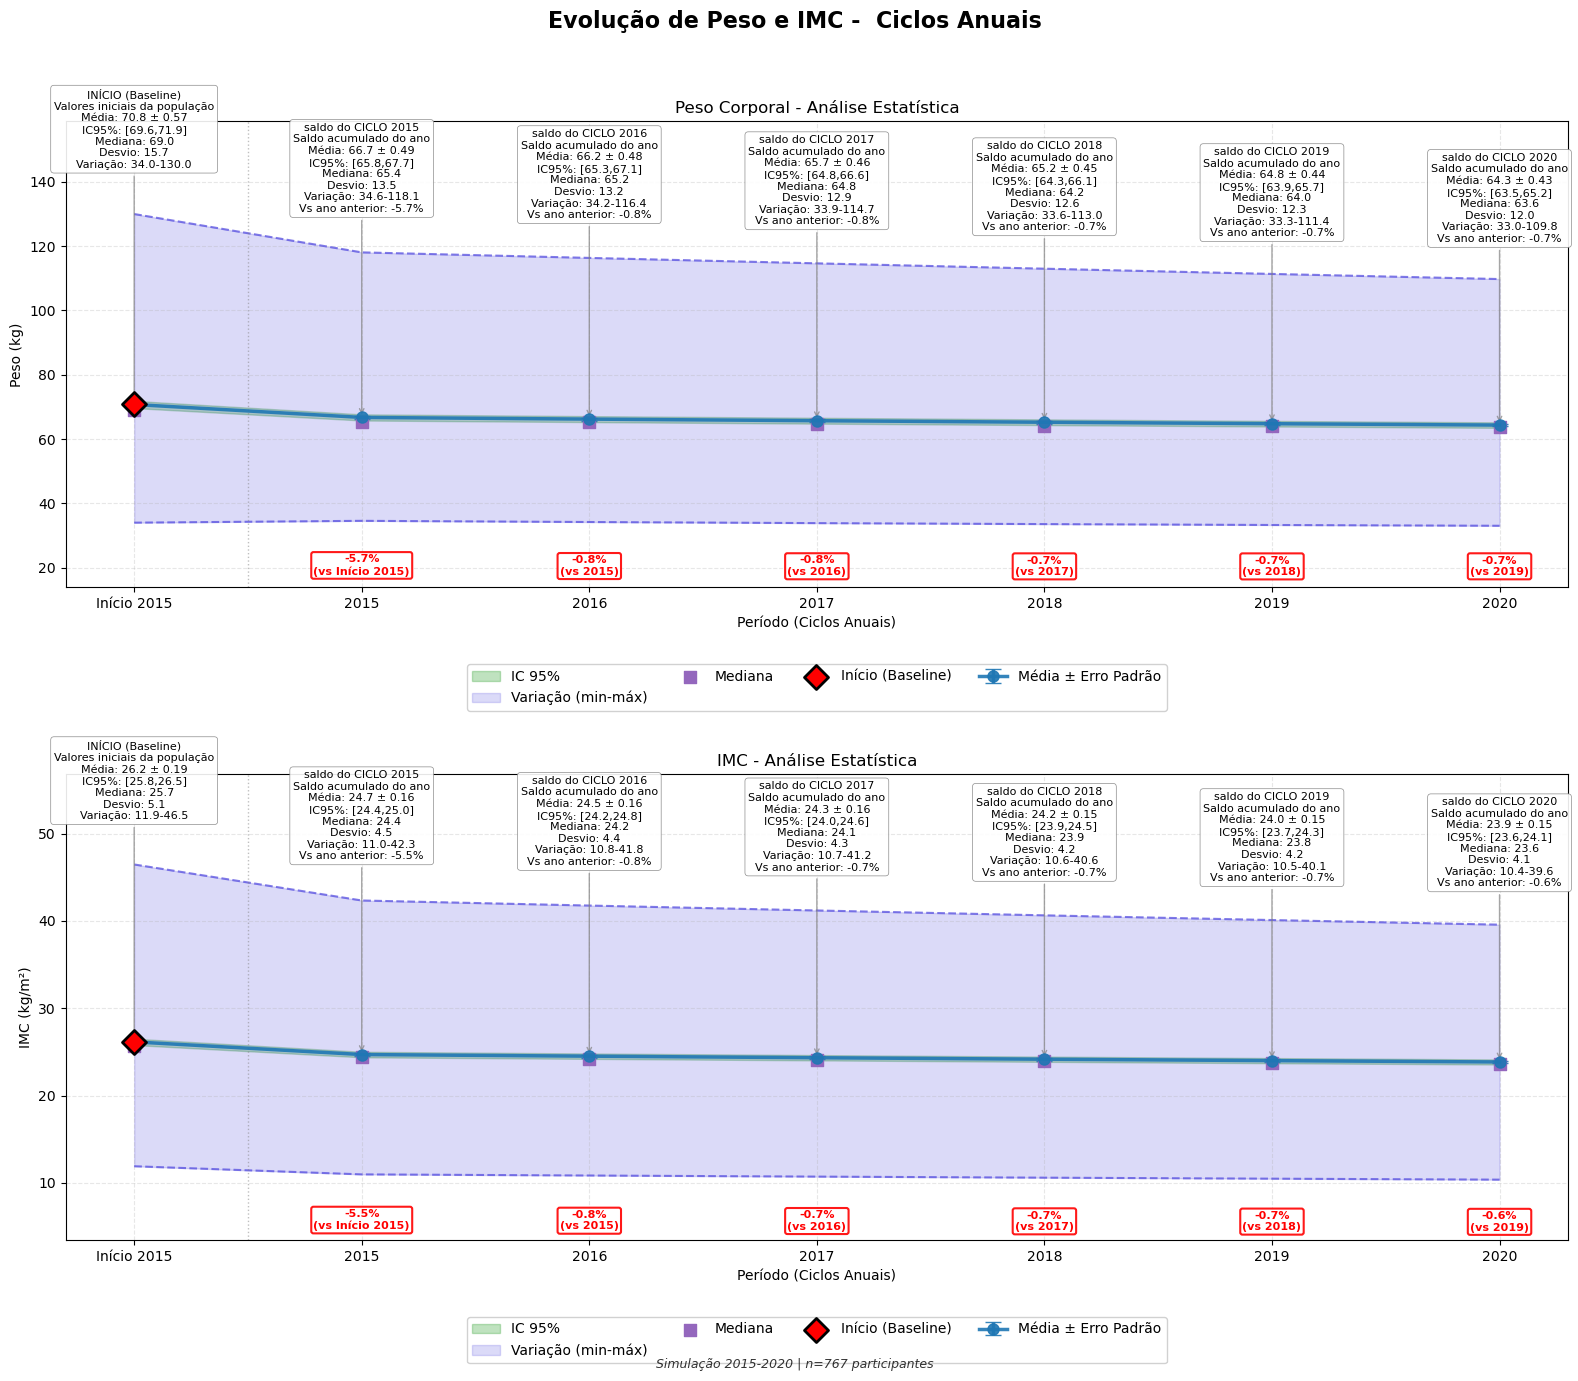

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator
import pandas as pd
# calculo estatísticas descritivas e intervalos de confiança (IC95%)
def analisar_estatisticas_peso_imc(df_final):
    anos = [2015, 2016, 2017, 2018, 2019, 2020] # Anos analisados
    anos_com_base = ['Início 2015'] + anos # Anos de Inicio (Baseline)
    cores = ['#1f77b4', "#0ecfff", '#2ca02c', "#4e46de", '#9467bd'] # paleta de cores
# estilo e ajuste de fontes

    plt.style.use('default')
    plt.rcParams.update({'font.family': 'DejaVu Sans', 'font.size': 10})
# funcao  para retorno do tipo e ano  em relacao ao coluna do dataframe

    def calcular_estatisticas_ano(tipo='Peso'):
        resultados = {k: [] for k in [
            'medias', 'medianas', 'desvios', 'erros_medios', 'ic95', 'variacoes',
            'minimos', 'maximos', 'amplitude', 'n_amostras', 'dentro_ic'
        ]}
        for i, periodo in enumerate(anos_com_base):
            coluna = f'{tipo}_2015_base' if periodo == 'Início 2015' else f'{tipo}_{periodo}'
            if coluna not in df_final.columns: 
                continue
            dados = df_final[coluna].dropna()
            if dados.empty: 
                continue
            #estatistica
            media, desvio, erro = dados.mean(), dados.std(), dados.sem()
            ic, minimo, maximo, amp = 1.96*erro, dados.min(), dados.max(), dados.max()-dados.min()
            pct_ic = ((dados >= media - ic) & (dados <= media + ic)).mean() * 100
            # variacao porcentual em relacao ao ano anterior
            if i == 0:
                variacao = 0
            else:
                anterior = df_final[f'{tipo}_2015_base' if anos_com_base[i-1]=='Início 2015' else f'{tipo}_{anos_com_base[i-1]}'].dropna()
                variacao = ((media - anterior.mean()) / anterior.mean() * 100) if len(anterior)>0 else 0
             # armazenamento de resultados  no dicionario
            for chave, valor in zip(resultados.keys(), 
                                    [media, dados.median(), desvio, erro, ic, variacao, minimo, maximo, amp, len(dados), pct_ic]):
                resultados[chave].append(valor)
                # conversao em lista via Numpy

        return {k: np.array(v) for k, v in resultados.items()}
# funcao para os graficos com a media, IC95%, MIN/MAX, mediana, mediana e variacao anual
    def criar_grafico(ax, dados, titulo, label_y):
        x = np.arange(len(dados['medias']))
        # curva principal: media +- erro padrao
        ax.errorbar(x, dados['medias'], yerr=dados['erros_medios'], fmt='-o', capsize=6, ms=8, lw=2.5,
                    color=cores[0], ecolor=cores[0], alpha=.9, label='Média ± Erro Padrão', zorder=5)
        #linha de confiança e variação total,medias,maximos e anotações
        ax.fill_between(x, dados['medias']-dados['ic95'], dados['medias']+dados['ic95'], color=cores[2], alpha=.3, label='IC 95%')
        ax.fill_between(x, dados['minimos'], dados['maximos'], color=cores[3], alpha=.2, label='Variação (min-máx)')
        ax.plot(x, dados['minimos'], '--', color=cores[3], alpha=.7)
        ax.plot(x, dados['maximos'], '--', color=cores[3], alpha=.7)
        ax.scatter(x, dados['medianas'], marker='s', s=80, color=cores[4], zorder=5, label='Mediana')
        ax.scatter([0], [dados['medias'][0]], marker='D', s=150, color='red', edgecolors='black', lw=2, zorder=10, label='Início (Baseline)')
        ax.axvline(0.5, color='gray', ls=':', alpha=.5, lw=1)
        
        for i in x:
            media, erro, ic, pct_ic, mediana = [dados[ch][i] for ch in ['medias','erros_medios','ic95','dentro_ic','medianas']]
            minimo, maximo, n, amp, variacao = [dados[ch][i] for ch in ['minimos','maximos','n_amostras','amplitude','variacoes']]
            nome = 'Início 2015' if i==0 else anos_com_base[i]
            texto = (f'INÍCIO (Baseline)\nValores iniciais da população\n' if i==0 else f'saldo do CICLO {nome}\nSaldo acumulado do ano\n') + \
                    f'Média: {media:.1f} ± {erro:.2f}\nIC95%: [{media-ic:.1f},{media+ic:.1f}]\nMediana: {mediana:.1f}\nDesvio: {dados["desvios"][i]:.1f}\nVariação: {minimo:.1f}-{maximo:.1f}' + \
                    ('' if i==0 else f'\nVs ano anterior: {variacao:+.1f}%')

            ax.annotate(texto, xy=(x[i], media), xytext=(x[i], maximo + amp * 0.15), ha='center', fontsize=8, color='black',
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9, ec="gray", lw=0.5),
                        arrowprops=dict(arrowstyle='->', color='gray', alpha=.7, lw=1))
             #exibicao de nivel porcentual
            if i>0:
                cor='green' if variacao>=0 else 'red'
                ax.annotate(f'{variacao:+.1f}%\n(vs {anos_com_base[i-1]})', xy=(x[i], media),
                            xytext=(x[i], minimo-amp*0.2), ha='center', fontsize=8, color=cor, weight='bold',
                            bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=.9, ec=cor, lw=1.5))
# Configuração de eixos

        ax.set(title=titulo, xlabel='Período (Ciclos Anuais)', ylabel=label_y)
        ax.set_xticks(x)
        ax.set_xticklabels(anos_com_base[:len(x)])
        ax.grid(True, alpha=.3, ls='--')
        ax.legend(loc='upper center', bbox_to_anchor=(0.5,-0.15), ncol=4, framealpha=.9)
        ax.xaxis.set_major_locator(MultipleLocator(1))
        amp_max = dados['amplitude'].max()
        ax.set_ylim(dados['minimos'].min()-amp_max*0.2, dados['maximos'].max()+amp_max*0.3)
# Calculo  das estatisticas para o  Peso e IMC

    stats_peso, stats_imc = calcular_estatisticas_ano('Peso'), calcular_estatisticas_ano('IMC')
    #Criação de Dois Subplots

    fig, axs = plt.subplots(2,1,figsize=(16,14))
    fig.suptitle('Evolução de Peso e IMC -  Ciclos Anuais', fontsize=16, fontweight='bold', y=.98)

    criar_grafico(axs[0], stats_peso, 'Peso Corporal - Análise Estatística', 'Peso (kg)')
    criar_grafico(axs[1], stats_imc, 'IMC - Análise Estatística', 'IMC (kg/m²)')

    plt.tight_layout(rect=[0,0,1,0.96])
    plt.subplots_adjust(hspace=.4)
    fig.text(0.5,0.01,f'Simulação {anos[0]}-{anos[-1]} | n={len(df_final)} participantes',
            ha='center', fontsize=9, style='italic', alpha=.8)
    plt.show()
    
    return stats_peso, stats_imc
#chamada da funcao
stats_peso, stats_imc = analisar_estatisticas_peso_imc(df_final)


# Decomposição

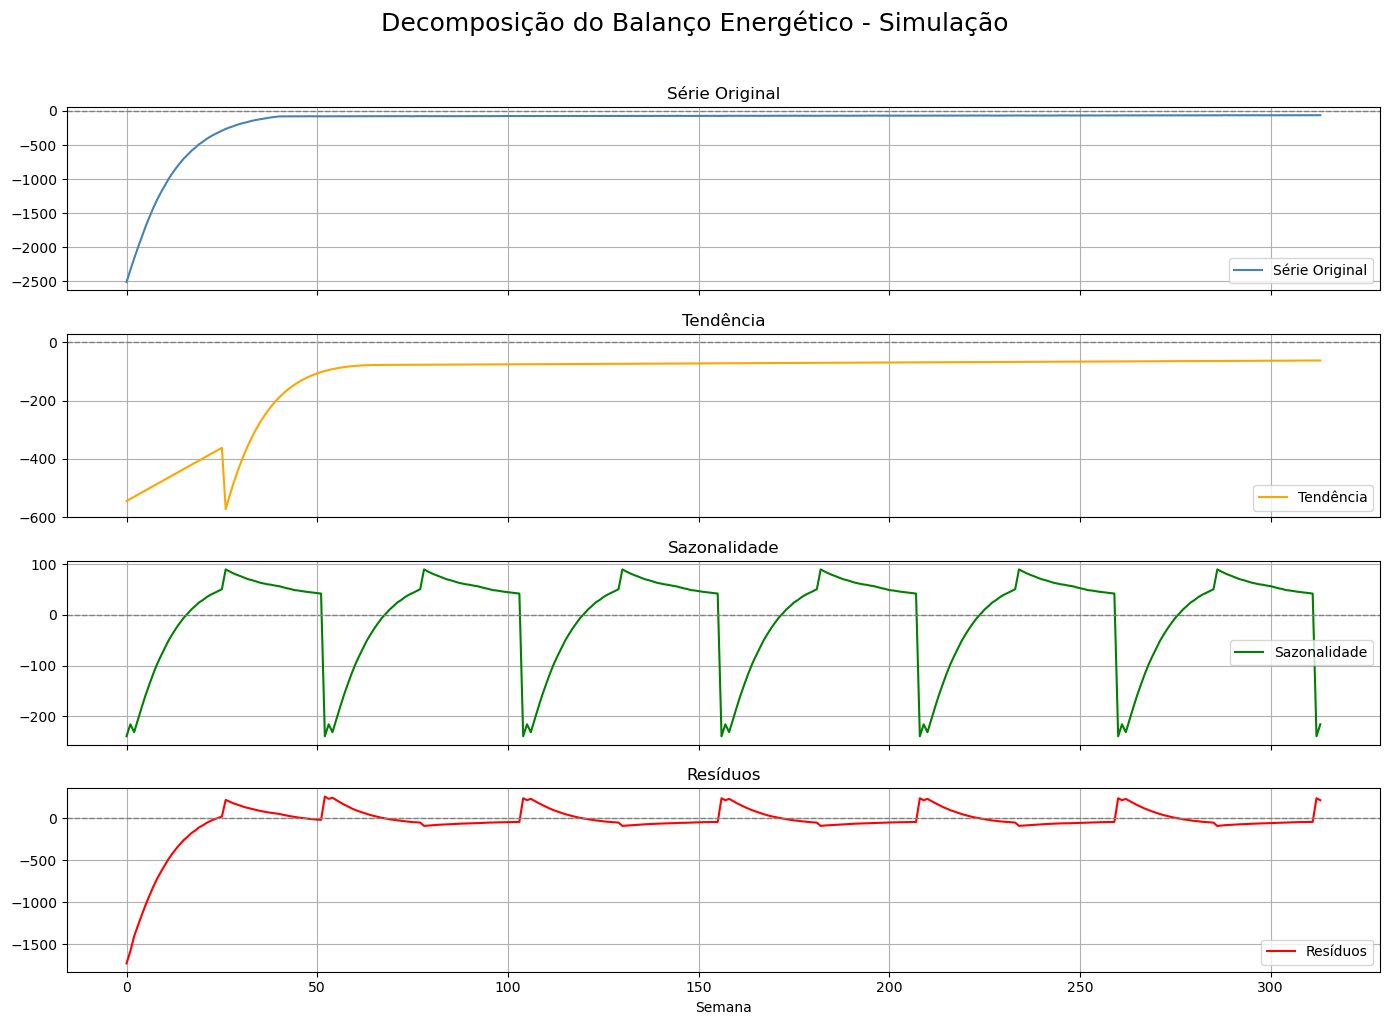


Estatísticas da Simulação
Tendência média = -117.77 kcal
Sazonalidade amplitude = 329.26 kcal
Resíduos média = -38.25 kcal, Desvio padrão = 233.28 kcal
Perturbações = 12


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


colunas_semana = [col for col in df_simulacao.columns if col.startswith('semana_')]

# Cálculo do balanço médio semanal de toda a população
balanco_medio_total = df_simulacao[colunas_semana].mean(axis=0).copy().values


decompo_resultado = seasonal_decompose(
    balanco_medio_total,
    model='additive',
    period=52,  
    extrapolate_trend='freq'
)

# Plotagem da decomposição
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
fig.subplots_adjust(hspace=0.4)
fig.suptitle("Decomposição do Balanço Energético - Simulação", fontsize=18, y=1.02)

axs[0].plot(balanco_medio_total, color='steelblue', label='Série Original')
axs[0].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[0].set_title('Série Original')
axs[0].grid(True)
axs[0].legend()

axs[1].plot(decompo_resultado.trend, color='orange', label='Tendência')
axs[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[1].set_title('Tendência')
axs[1].grid(True)
axs[1].legend()

axs[2].plot(decompo_resultado.seasonal, color='green', label='Sazonalidade')
axs[2].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[2].set_title('Sazonalidade')
axs[2].grid(True)
axs[2].legend()

axs[3].plot(decompo_resultado.resid, color='red', label='Resíduos')
axs[3].axhline(0, color='gray', linestyle='--', linewidth=1)
axs[3].set_title('Resíduos')
axs[3].set_xlabel('Semana')
axs[3].grid(True)
axs[3].legend()

plt.tight_layout()
plt.show()

# Estatísticas da decomposição
print("\nEstatísticas da Simulação")
print(f"Tendência média = {np.nanmean(decompo_resultado.trend):.2f} kcal")
print(f"Sazonalidade amplitude = {np.nanmax(decompo_resultado.seasonal) - np.nanmin(decompo_resultado.seasonal):.2f} kcal")
print(f"Resíduos média = {np.nanmean(decompo_resultado.resid):.2f} kcal, Desvio padrão = {np.nanstd(decompo_resultado.resid):.2f} kcal")
print(f"Perturbações = {np.sum(np.abs(decompo_resultado.resid[~np.isnan(decompo_resultado.resid)]) > 2 * np.nanstd(decompo_resultado.resid))}")


# Visualização Estado Nutricional

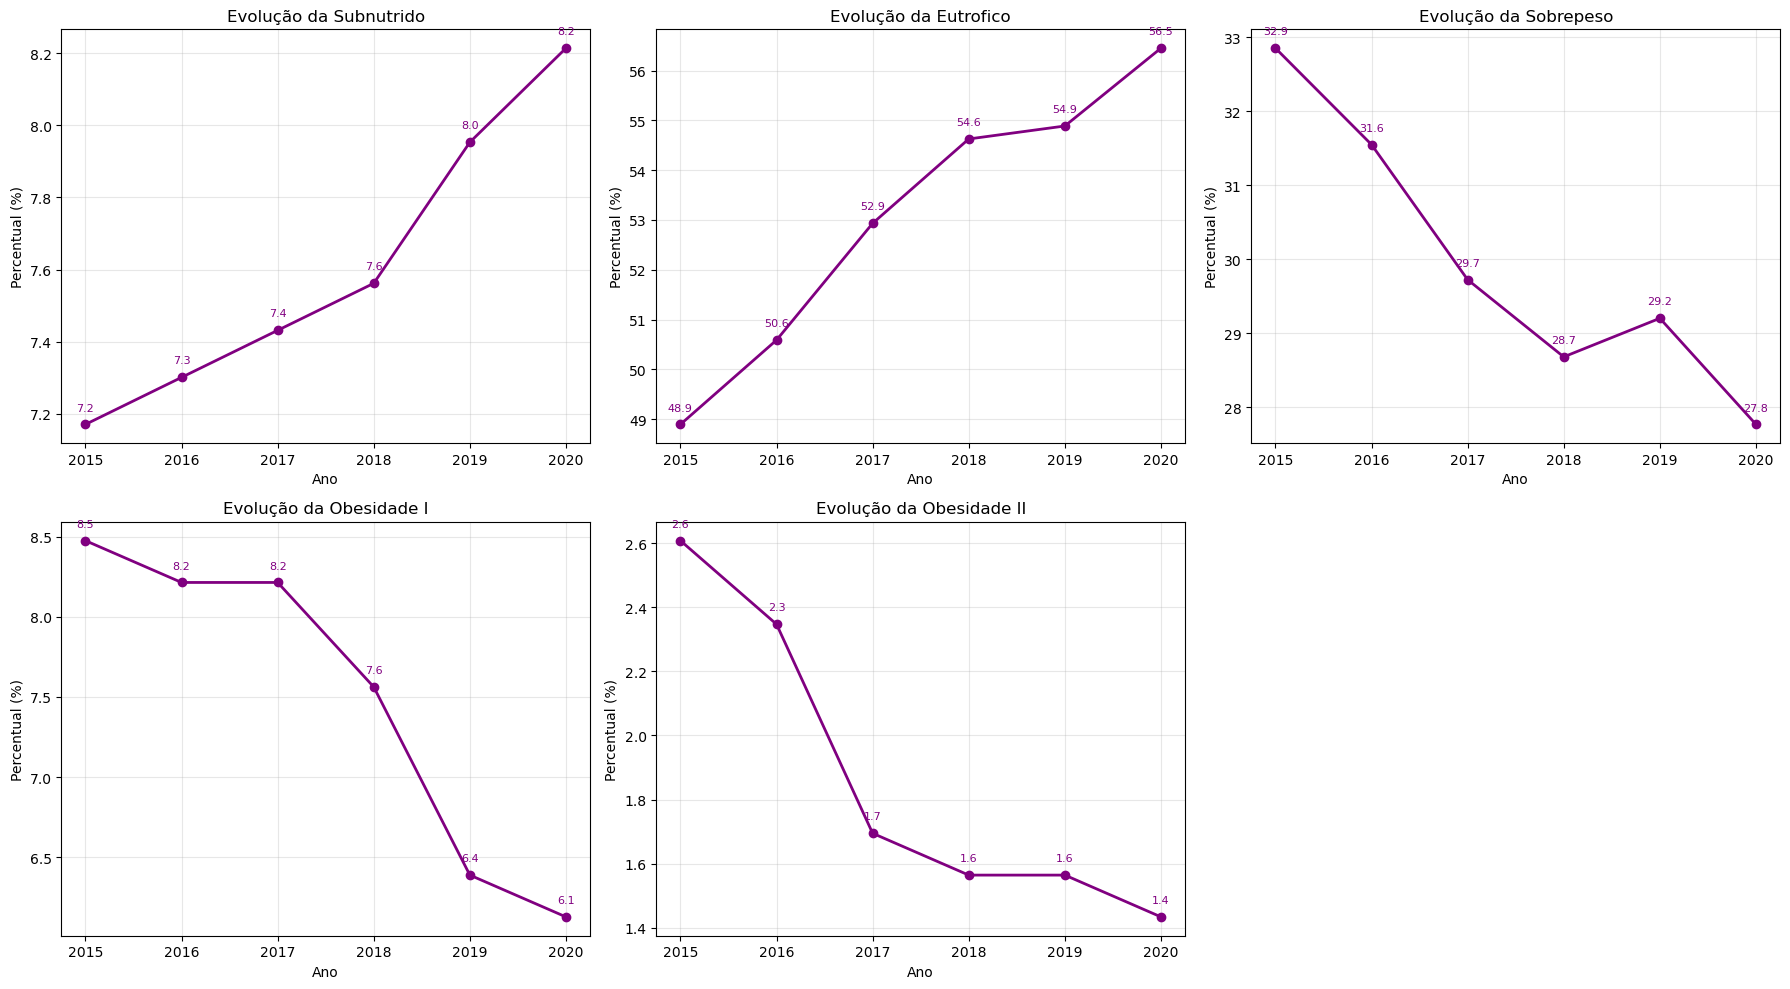

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
# funcao de classificao do imc
def classificar_imc(imc):
    if imc < 18.5: 
        return 'Subnutrido'
    elif 18.5 <= imc < 25: 
        return 'Eutrofico'
    elif 25 <= imc < 30: 
        return 'Sobrepeso'
    elif 30 <= imc < 35: 
        return 'Obesidade I'
    else: 
        return 'Obesidade II'
# plotagem da evoluçaão das do individuos
def plotar_evolucao(df_final):
    categorias = ['Subnutrido', 'Eutrofico', 'Sobrepeso', 'Obesidade I', 'Obesidade II']
    
    # Colunas de IMC contrafactual
    colunas_imc = [
        'IMC_2015', 'IMC_2016', 
        'IMC_2017', 'IMC_2018',
        'IMC_2019', 'IMC_2020'
    ]
    anos = [2015, 2016, 2017, 2018, 2019, 2020]
    # grade de subplots (2 linhas x 3 colunas)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
   # Loop para gráfico por categoria
    for idx, categoria in enumerate(categorias):
        if idx < len(axes):
            ax = axes[idx]
            percentuais = []
            for col in colunas_imc:
                classificacoes = df_final[col].apply(classificar_imc)
                percentual = (classificacoes == categoria).sum() / len(df_final) * 100
                percentuais.append(percentual)

            # tendência temporal
            line = ax.plot(anos, percentuais, 'o-', linewidth=2, color='purple')[0]

            # valores porcentuais
            for i, (ano, percentual) in enumerate(zip(anos, percentuais)):
                if percentual >= 0:
                    ax.annotate(f'{percentual:.1f}', 
                                (ano, percentual), 
                                textcoords="offset points", 
                                xytext=(0,10), 
                                ha='center', 
                                fontsize=8,
                                color=line.get_color())
            
            ax.set_title(f'Evolução da {categoria}')
            ax.set_xlabel('Ano')
            ax.set_ylabel('Percentual (%)')
            ax.grid(True, alpha=0.3)
            ax.set_xticks(anos)

    if len(categorias) < len(axes):
        for idx in range(len(categorias), len(axes)):
            fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()
plotar_evolucao(df_final)

In [10]:
df= df_final.copy()

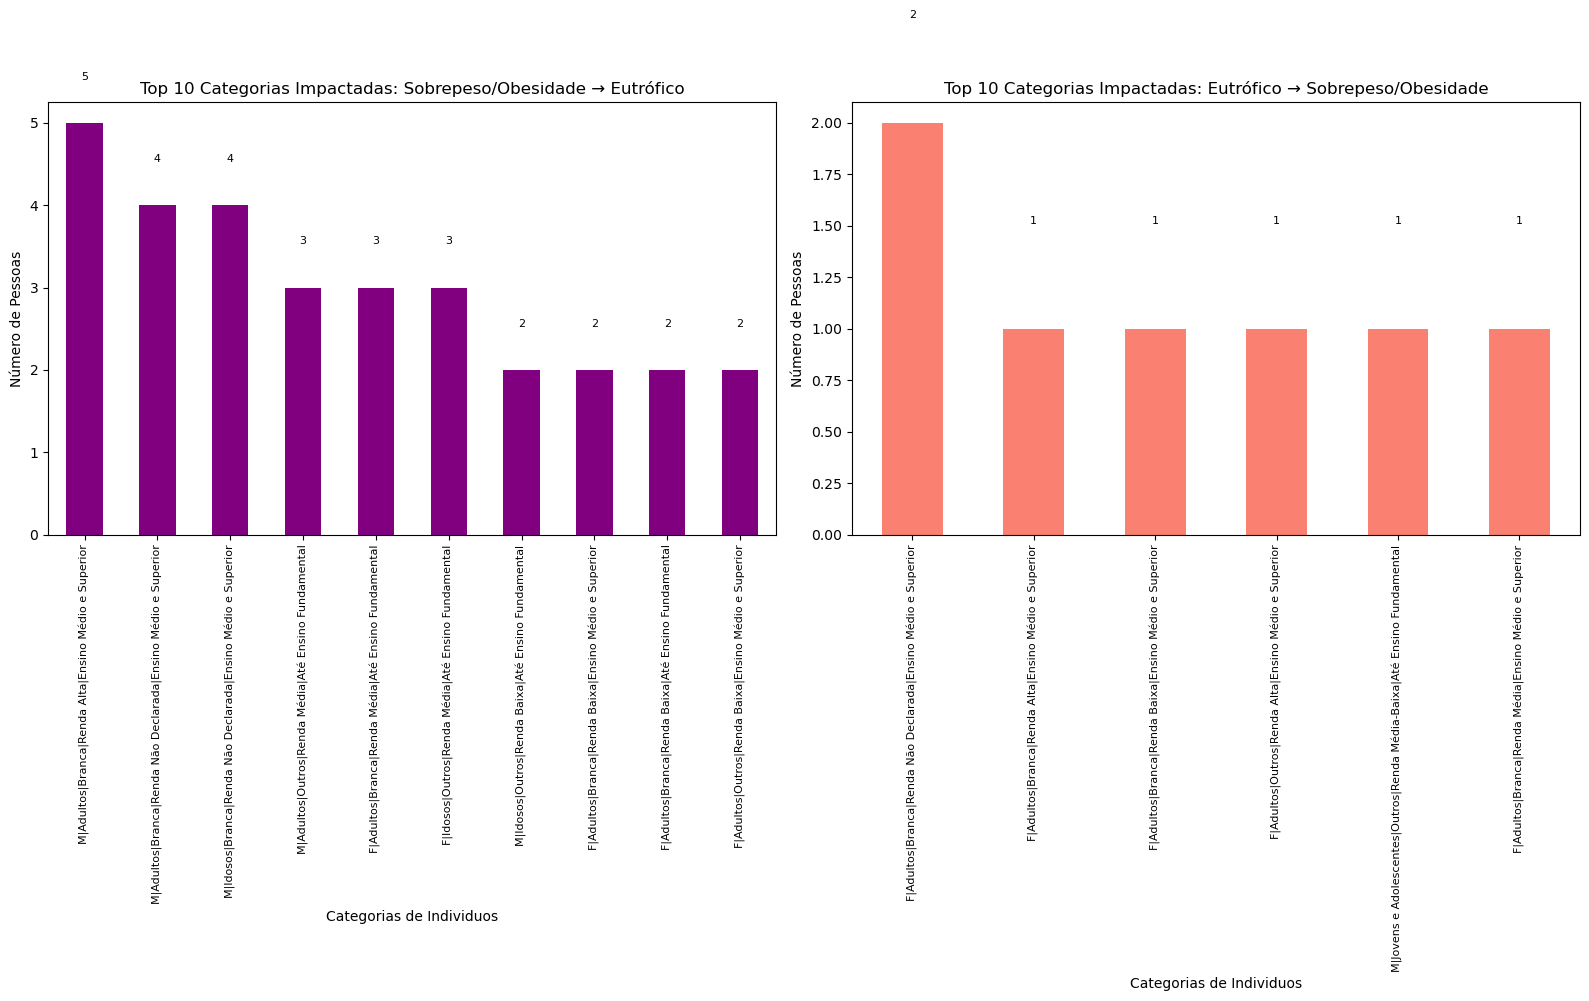

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# classificação do imc
def classificar_imc(imc):
    if imc < 18.5:
        return 'Subnutrido'
    elif imc < 25:
        return 'Eutrófico'
    elif imc < 30:
        return 'Sobrepeso'
    elif imc < 35:
        return 'Obesidade I'
    else:
        return 'Obesidade II'

#categóricas de IMC para os anos de 2015 e 2020
df['Cat_2015'] = df['IMC_2015'].apply(classificar_imc)
df['Cat_2020'] = df['IMC_2020'].apply(classificar_imc)


melhorou = df[df['Cat_2015'].isin(['Sobrepeso','Obesidade I','Obesidade II']) & (df['Cat_2020'] == 'Eutrófico')]
piorou  = df[(df['Cat_2015'] == 'Eutrófico') & df['Cat_2020'].isin(['Sobrepeso','Obesidade I','Obesidade II'])]


top_melhorou = melhorou['Categorias'].value_counts().head(10)
top_piorou   = piorou['Categorias'].value_counts().head(10)


# plotagem das categorias
def plot_top(ax, data, titulo, cor, mensagem_vazio):
    if not data.empty:
        data.plot(kind='bar', color=cor, ax=ax)
        ax.set_title(titulo)
        ax.set_ylabel('Número de Pessoas')
        ax.set_xlabel('Categorias de Individuos')
        ax.set_xticklabels(data.index, rotation=90, fontsize=8)
        for i, v in enumerate(data):
            ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)
    else:
        ax.text(0.5, 0.5, mensagem_vazio, ha='center', va='center', fontsize=12)
        ax.set_axis_off()


fig, axes = plt.subplots(1, 2, figsize=(16, 7))
plot_top(axes[0], top_melhorou, 'Top 10 Categorias Impactadas: Sobrepeso/Obesidade → Eutrófico', 'purple', 'Nenhum registro')
plot_top(axes[1], top_piorou, 'Top 10 Categorias Impactadas: Eutrófico → Sobrepeso/Obesidade', 'salmon', 'Nenhum indivíduo passo de Eutrófico para Sobrepeso/Obesidade')

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()


C:\Users\vimed\AppData\Local\Temp\ipykernel_71872\501643903.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(top_classe.index, rotation=45, ha='right')
C:\Users\vimed\AppData\Local\Temp\ipykernel_71872\501643903.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


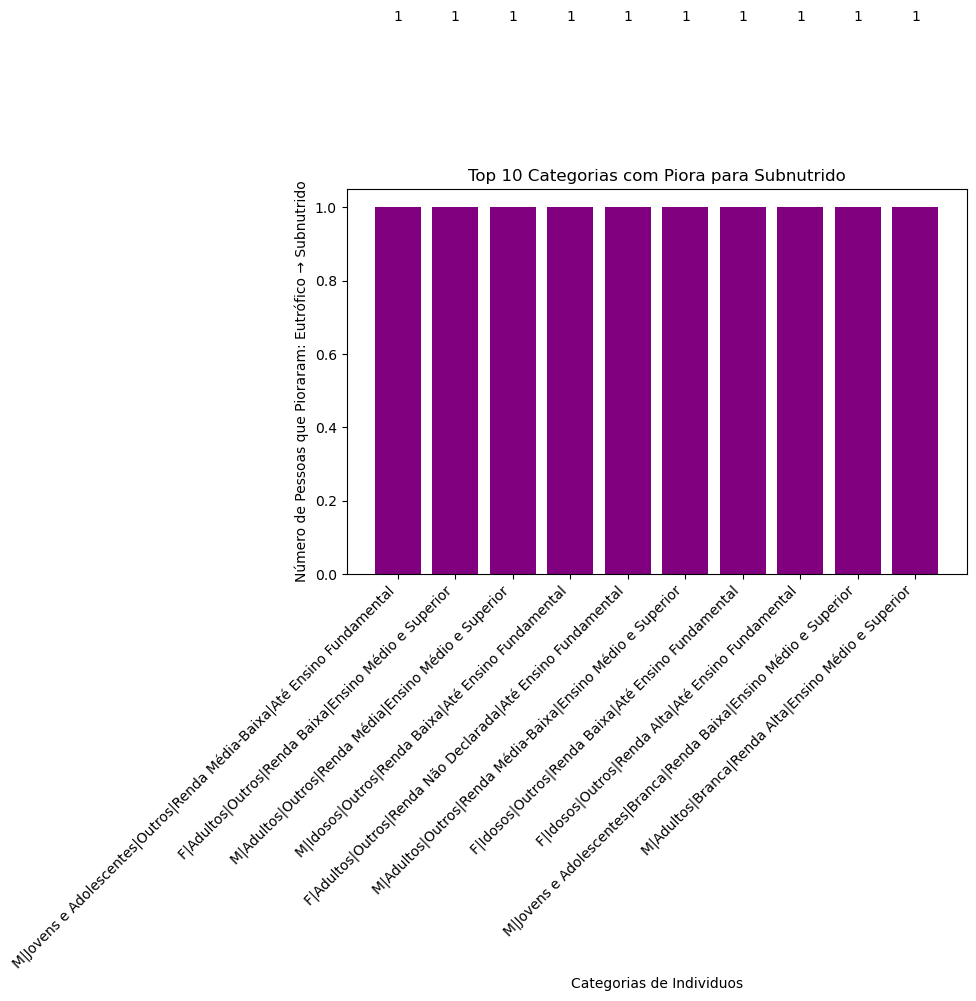

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# classificacao do imc
def classificar_imc(imc):
    if imc < 18.5:
        return 'Subnutrido'
    elif imc < 25:
        return 'Eutrófico'
    elif imc < 30:
        return 'Sobrepeso'
    elif imc < 35:
        return 'Obesidade I'
    else:
        return 'Obesidade II'
 # categóricas de IMC para os anos de 2015 e 2020
df['Cat_2015'] = df['IMC_2015'].apply(classificar_imc)
df['Cat_2020'] = df['IMC_2020'].apply(classificar_imc)

piorou_subnutrido = df[
    (df['Cat_2015'] == 'Eutrófico') & (df['Cat_2020'] == 'Subnutrido')
]

top_classe = piorou_subnutrido['Categorias'].value_counts().head(10)

if not top_classe.empty:
    fig, ax = plt.subplots(figsize=(8,5))
    bars = ax.bar(top_classe.index, top_classe.values, color='purple')
    
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(height),
                ha='center', va='bottom', fontsize=10)
    
    ax.set_ylabel('Número de Pessoas que Pioraram: Eutrófico → Subnutrido')
    ax.set_xlabel('Categorias de Individuos')
    ax.set_title('Top 10 Categorias com Piora para Subnutrido')
    ax.set_xticklabels(top_classe.index, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()



# Visualizacao via Mapa

In [13]:
import pandas as pd
import warnings

warnings.simplefilter("ignore", UnicodeWarning)

df = pd.read_stata(r"C:\Users\vimed\Downloads\Banco_ISA_AF_Ambiente_Vinicius (5).dta")

df = df.filter([
    'id_original', 'N_domicilio',
    'lat2015', 'long2015', 'lat2020', 'long2020'
])



In [14]:
df_final = df.merge(df_final, left_on='id_original', right_on='id', how='inner')


Text(0.5, 1.0, 'Mapa dos Indivíduos via IMC 2020 Baseline - São Paulo')

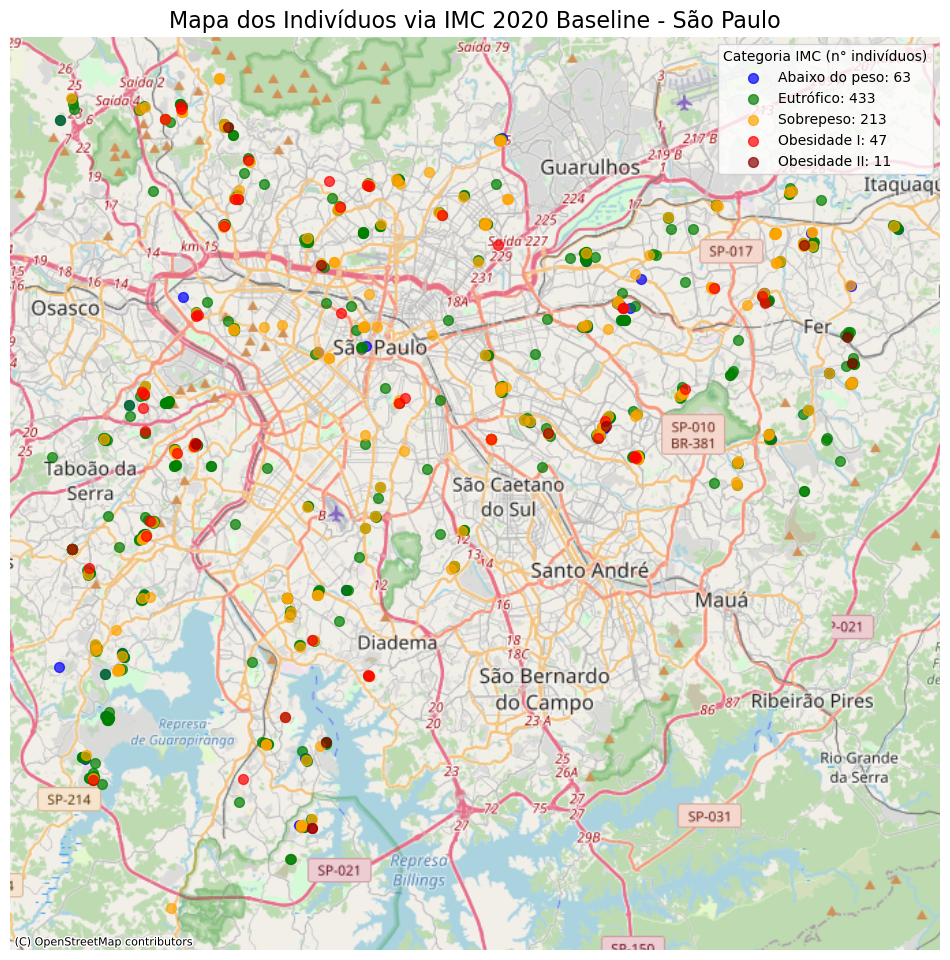

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import contextily as ctx
import geopandas as gpd
from shapely.geometry import Point

df_heat = df_final.dropna(subset=["lat2020", "long2020", "IMC_2020"]).copy()

# funcao para classificar o imc dos individuos
def classificar_imc(imc):
    if imc < 18.5: return "Abaixo do peso"
    elif 18.5 <= imc < 25: return "Eutrófico"
    elif 25 <= imc < 30: return "Sobrepeso"
    elif 30 <= imc < 35: return "Obesidade I"
    else: return "Obesidade II"

# aplicacao da funcao do imc
df_heat["categoria_imc"] = df_heat["IMC_2020"].apply(classificar_imc)
# criacao do geod dataframe via coordeadas
gdf = gpd.GeoDataFrame(
    df_heat,
    geometry=[Point(xy) for xy in zip(df_heat["long2020"], df_heat["lat2020"])],
    crs="EPSG:4326"
)
# transformacao para aplicar a biblioteca contextuality
gdf = gdf.to_crs(epsg=3857)
# paleta de cores
cores = {
    "Abaixo do peso": "blue",
    "Eutrófico": "green",
    "Sobrepeso": "orange",
    "Obesidade I": "red",
    "Obesidade II": "darkred"
}

fig, ax = plt.subplots(figsize=(12,12))

legendas = []
# plotar categoria por cor
for categoria, cor in cores.items():
    subset = gdf[gdf["categoria_imc"] == categoria]
    if not subset.empty:
        subset.plot(ax=ax, markersize=50, color=cor, alpha=0.7)
        legendas.append(f"{categoria}: {len(subset)}")

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_axis_off()

plt.legend(legendas, title="Categoria IMC (n° indivíduos)", loc="upper right", fontsize=10)
plt.title("Mapa dos Indivíduos via IMC 2020 Baseline - São Paulo", fontsize=16)


In [16]:
!pip install geopandas matplotlib contextily folium  selenium pillow webdriver-manager overpy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
df_final = df_final.loc[:, ~df_final.columns.str.endswith(('_x', '_y'))]


In [18]:
import pandas as pd

df_dados_Geo = pd.read_csv('C:\\Users\\vimed\\Downloads\\Dados_geograficos_Referencia.csv')


In [19]:
df_final = df_final.merge(df_dados_Geo, left_on='id_original', right_on='id', how='inner')


In [20]:
df_final = df_final.loc[:, ~df_final.columns.str.endswith(('_x', '_y'))]


In [21]:
# Aplicar classificação no DataFrame principal
df_final['categoria_imc'] = df_final['IMC_2020'].apply(classificar_imc)

# Agregar IMC médio por bairro e categoria
df_agg = df_final.groupby(['bairro', 'regiao_cardinal', 'categoria_imc'], as_index=False)['IMC_2020'].mean().rename(columns={'IMC_2020':'imc_medio'})


C:\Users\vimed\AppData\Local\Temp\ipykernel_71872\1749793249.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_71872\1749793249.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_71872\1749793249.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\vimed\AppData\Local\Temp\ipykernel_71872\1749793249.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `h

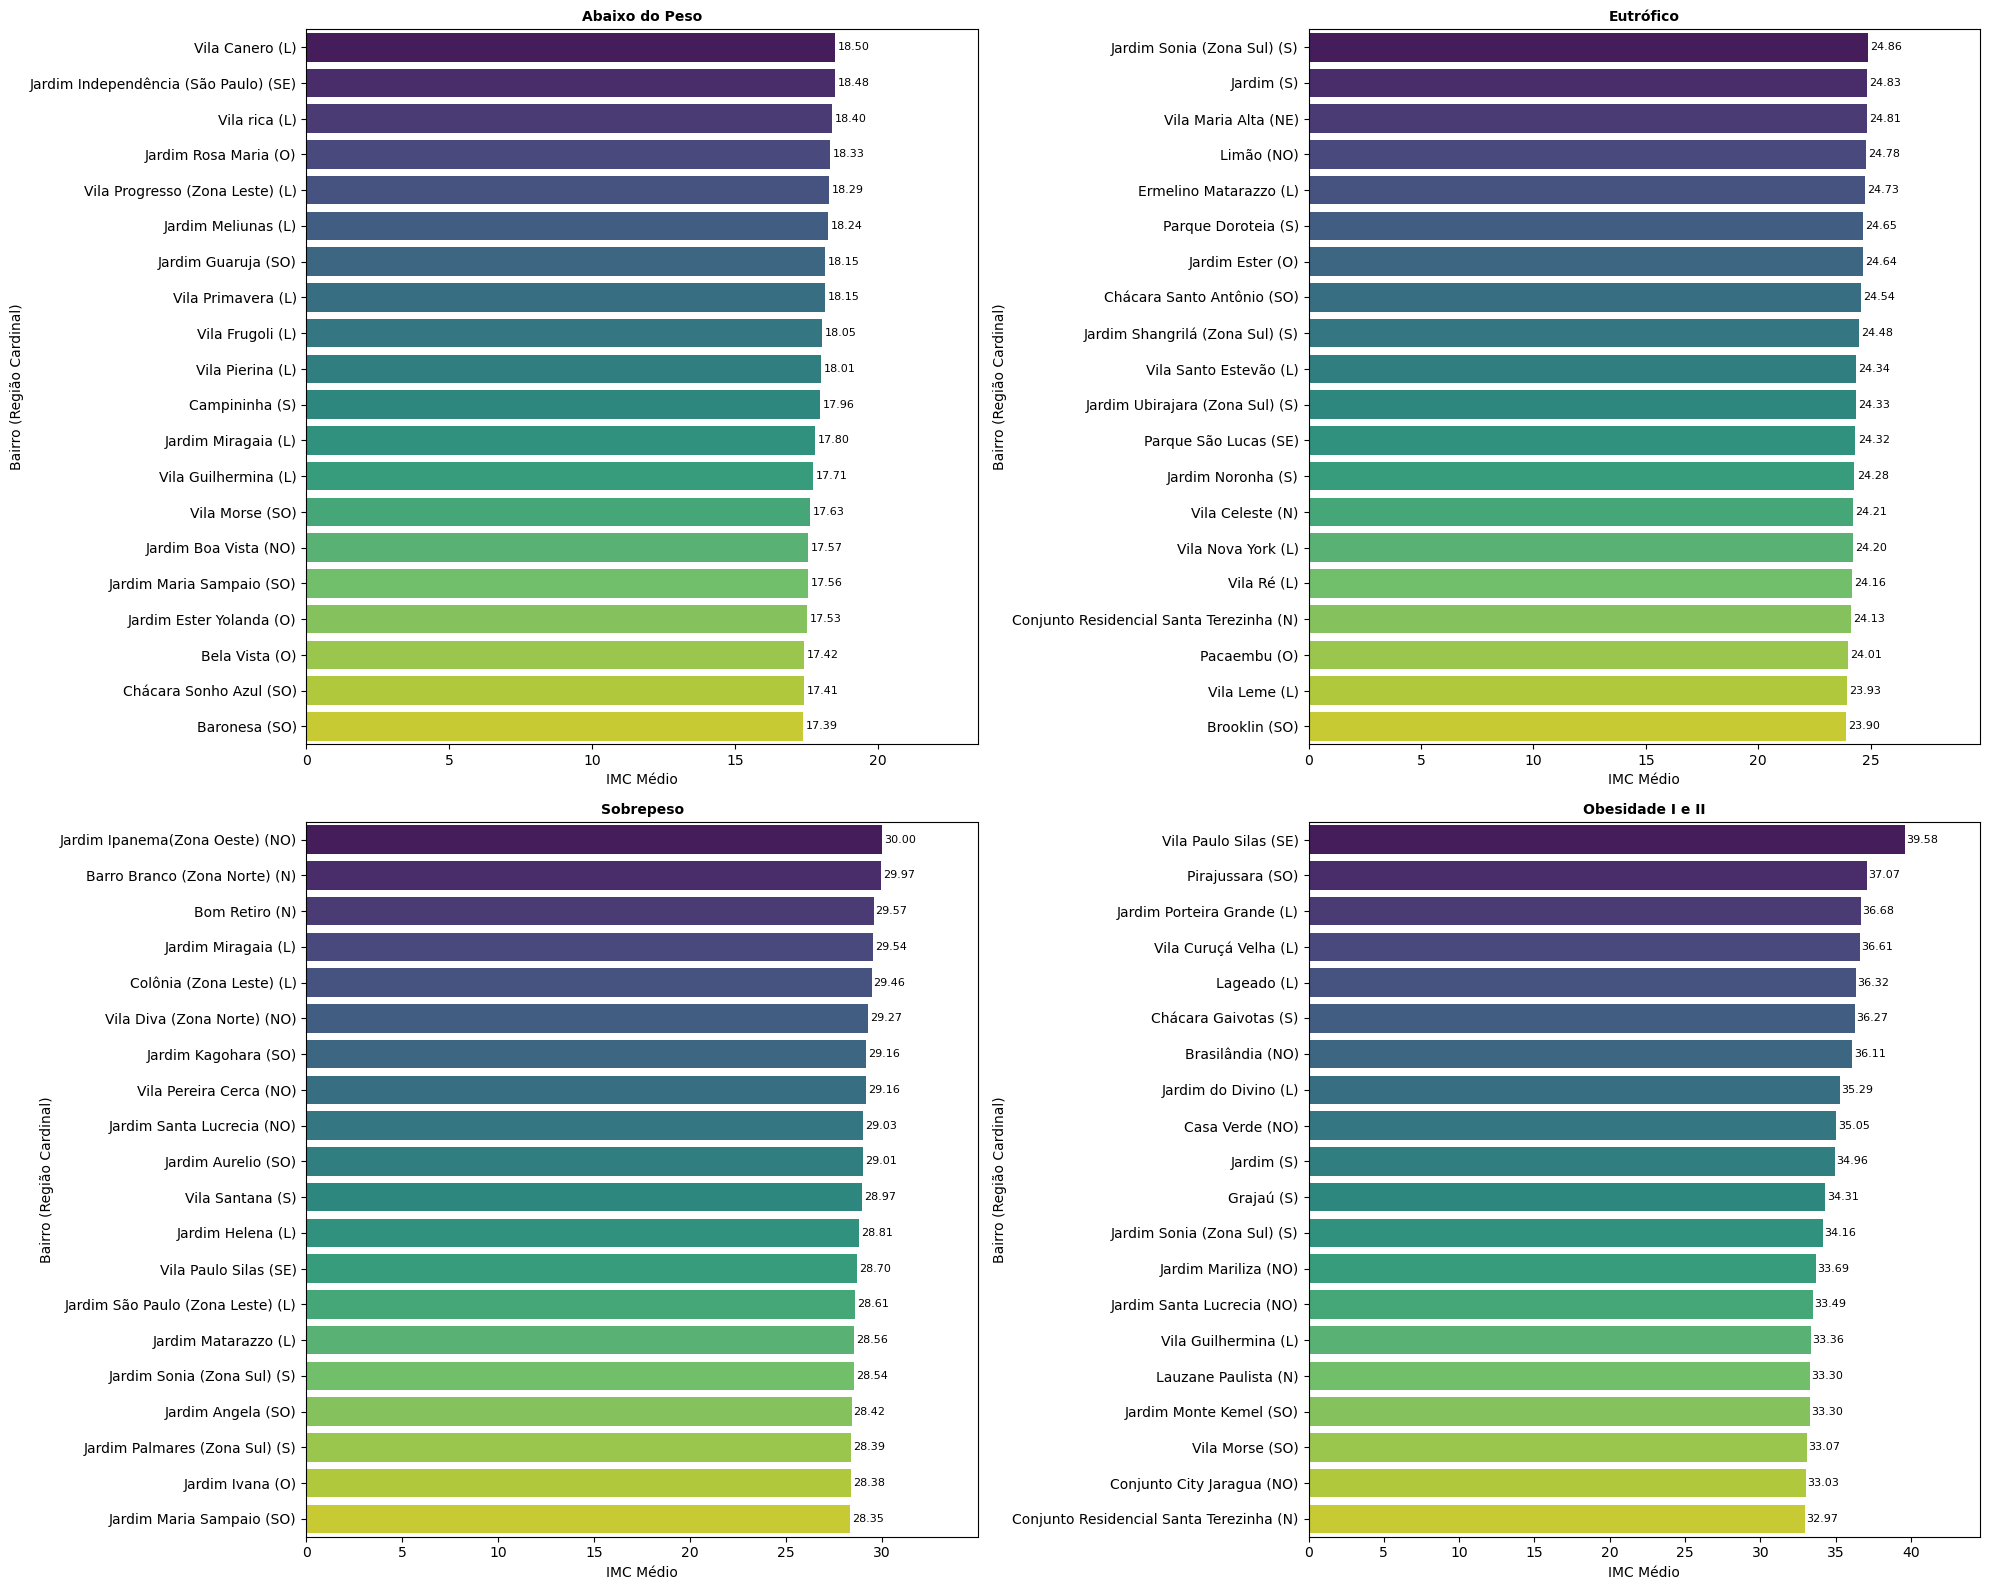

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Função de classificação
def classificar_imc(imc):
    if imc < 18.5:
        return "Abaixo do Peso"
    elif 18.5 <= imc < 25:
        return "Eutrófico"
    elif 25 <= imc < 30:
        return "Sobrepeso"
    elif 30 <= imc < 35:
        return "Obesidade I"
    else:
        return "Obesidade II"

# Aplicar classificação
df_final['categoria_imc'] = df_final['IMC_2020'].apply(classificar_imc)

# Criar DataFrames separados por categoria
df_abaixo_peso = df_final[df_final['categoria_imc'] == "Abaixo do Peso"]
df_eutrofico    = df_final[df_final['categoria_imc'] == "Eutrófico"]
df_sobrepeso    = df_final[df_final['categoria_imc'] == "Sobrepeso"]
df_obesidade    = df_final[df_final['categoria_imc'].isin(["Obesidade I", "Obesidade II"])]

# Agregar IMC médio por bairro
def agregar_imc(df):
    return df.groupby(['bairro', 'regiao_cardinal'], as_index=False)['IMC_2020'].mean().rename(columns={'IMC_2020':'imc_medio'})

df_abaixo_peso_agg = agregar_imc(df_abaixo_peso)
df_eutrofico_agg    = agregar_imc(df_eutrofico)
df_sobrepeso_agg    = agregar_imc(df_sobrepeso)
df_obesidade_agg    = agregar_imc(df_obesidade)

# Função para plotar Top 20 bairros por IMC médio
def plot_top20_ax(ax, df_agg, categoria_nome):
    top20 = df_agg.sort_values(by='imc_medio', ascending=False).head(20).reset_index(drop=True)
    top20['bairro_regiao'] = top20['bairro'] + ' (' + top20['regiao_cardinal'] + ')'
    
    sns.barplot(
        data=top20,
        y='bairro_regiao',
        x='imc_medio',
        palette="viridis",
        dodge=False,
        ax=ax
    )
    
    for i, v in enumerate(top20['imc_medio']):
        ax.text(v + 0.1, i, f"{v:.2f}", color='black', va='center', fontsize=8)
    
    ax.set_title(categoria_nome, fontsize=10, fontweight='bold')
    ax.set_xlabel('IMC Médio')
    ax.set_ylabel('Bairro (Região Cardinal)')
    max_val = top20['imc_medio'].max()
    ax.set_xlim(0, max_val + 5)

# Criar figura 2x2
fig, axs = plt.subplots(2, 2, figsize=(20, 16))
axs = axs.flatten()

categorias = [
    ("Abaixo do Peso", df_abaixo_peso_agg),
    ("Eutrófico", df_eutrofico_agg),
    ("Sobrepeso", df_sobrepeso_agg),
    ("Obesidade I e II", df_obesidade_agg)
]

for ax, (nome, df_cat) in zip(axs, categorias):
    plot_top20_ax(ax, df_cat, nome)

plt.tight_layout()
plt.show()
